In [352]:
import torch
import numpy as np
import math
import os
import pandas as pd

from tqdm import tqdm

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from prompt_risk.bounds import *
from prompt_risk.utils import *

import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('seaborn-v0_8')

In [353]:
bj_bounds = dict()

In [359]:
def binedges_equalmass(x, n_bins):
    n = len(x)
    return np.interp(np.linspace(0, n, n_bins + 1),
                     np.arange(n),
                     np.sort(x))

def find_bin_edges_equal_mass_src(source_data, n_bins, clf):
    ## compute iw using training set
    w_list_train = []
    X_source = source_data[0]
    w_source = 1/clf.predict_proba(X_source)[:, 1]-1

    bin_edges = binedges_equalmass(list(w_source), n_bins)
    bin_edges[0] = 0.0
    bin_edges[-1] = np.inf
    return bin_edges

def bci_clopper_pearson(k, n, alpha, two_side=True, use_R=False):
    if two_side:
        if use_R: # R is numerically better when alpha is small
            from rpy2.robjects.packages import importr
            stats = importr('stats')

            lo = stats.qbeta(alpha/2, int(k), int(n-k+1))[0]
            hi = stats.qbeta(1 - alpha/2, int(k+1), int(n-k))[0]
        else:
            from scipy import stats

            lo = stats.beta.ppf(alpha/2, k, n-k+1)
            hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)
        
            lo = 0.0 if math.isnan(lo) else lo
            hi = 1.0 if math.isnan(hi) else hi
    
        return lo, hi
    else:
        if use_R: # R is numerically better when alpha is small
            from rpy2.robjects.packages import importr
            stats = importr('stats')

            hi = stats.qbeta(1 - alpha, int(k+1), int(n-k))[0]
        else:
            from scipy import stats

            hi = stats.beta.ppf(1 - alpha, k+1, n-k)
            hi = 1.0 if math.isnan(hi) else hi
    
        return hi

def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) and len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

In [355]:
chat_root = "full"
filepath = "../llm_output/{}_chat/google-flan-t5-xxl_predictions.csv".format(chat_root)
# filepath = "../llm_output/cnn_dailymail/meta-llama-Llama-2-7b-chat-hf_predictions.csv"
source_df = pd.read_csv(filepath)

test_hyp = None
for h in source_df["hypothesis"].unique():
    rows = source_df[source_df["hypothesis"] == h]
    if len(rows) == 40000:
        test_hyp = h
        break

print("hyp:", test_hyp)
source_df = source_df[source_df["hypothesis"] == test_hyp]
source_df = source_df.sort_values(["task_id"])
source_tasks = source_df["task_id"].tolist()

source_emb_df = pd.read_csv("../llm_output/{}_chat/sentence-transformers-multi-qa-mpnet-base-dot-v1_embeddings.csv".format(chat_root))
# source_emb_df = pd.read_csv("../llm_output/cnn_dailymail/sentence-transformers-multi-qa-mpnet-base-dot-v1_embeddings.csv")
source_emb_df = source_emb_df.sort_values(["task_id"])
source_emb_tasks = source_emb_df["task_id"].tolist()

assert source_tasks == source_emb_tasks

/tmp/ipykernel_32007/2045969602.py:4: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  source_df = pd.read_csv(filepath)


hyp: {'instruction': 'You are a helpful chatbot. Your mission is to provide accurate information, share wisdom, and be friendly.'}


In [360]:
chat_root = "red_team"
filepath = "../llm_output/{}_chat/google-flan-t5-xxl_predictions.csv".format(chat_root)
# filepath = "../llm_output/xsum/meta-llama-Llama-2-7b-chat-hf_predictions.csv"
target_df = pd.read_csv(filepath)

target_df = target_df[target_df["hypothesis"] == test_hyp]
target_df = target_df.sort_values(["task_id"])
target_tasks = target_df["task_id"].tolist()

target_emb_df = pd.read_csv("../llm_output/{}_chat/sentence-transformers-multi-qa-mpnet-base-dot-v1_embeddings.csv".format(chat_root))
# target_emb_df = pd.read_csv("../llm_output/xsum/sentence-transformers-multi-qa-mpnet-base-dot-v1_embeddings.csv")
target_emb_df = target_emb_df.sort_values(["task_id"])
target_emb_tasks = target_emb_df["task_id"].tolist()

assert target_tasks == target_emb_tasks

/tmp/ipykernel_32007/4242963019.py:4: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  target_df = pd.read_csv(filepath)


In [426]:
X_source = np.array([eval(s) for s in source_emb_df["embedding"].tolist()])
z_source = np.array(source_df["toxicity"].tolist())

X_source.shape, z_source.shape

((40000, 768), (40000,))

In [427]:
X_target = np.array([eval(s) for s in target_emb_df["embedding"].tolist()])
z_target = np.array(target_df["toxicity"].tolist())

X_target.shape, z_target.shape

((38961, 768), (38961,))

In [444]:
X_source.shape, z_source.shape, X_target.shape, z_target.shape

((40000, 768), (40000,), (38961, 768), (38961,))

In [445]:
n_bins = 5
delta_w = 0.05
delta_b = 0.05
E = 1e-5
train_prop = 0.2

In [446]:
torch.manual_seed(0)
np.random.seed(0)

n_source = X_source.shape[0]
n_target = X_target.shape[0]

y_source = np.ones(n_source)
y_target = np.zeros(n_target)

X = np.concatenate([X_source, X_target])
y = np.concatenate([y_source, y_target])
z = np.concatenate([z_source, z_target])

n_train = int(n_source*train_prop)
X, y, z = unison_shuffled_copies(X, y, z)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]
z_train, z_test = z[:n_train], z[n_train:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(z_train.shape, z_test.shape)

(8000, 768) (70961, 768)
(8000,) (70961,)
(8000,) (70961,)


In [447]:
clf = MLPClassifier(
    hidden_layer_sizes=(100,100), 
    random_state=1, 
    max_iter=100, 
    verbose=True
).fit(X_train, y_train)

score = clf.score(X_test, y_test)
print("score", score)

Iteration 1, loss = 0.54316574
Iteration 2, loss = 0.46012102
Iteration 3, loss = 0.43268574
Iteration 4, loss = 0.40884937
Iteration 5, loss = 0.38113180
Iteration 6, loss = 0.35265614
Iteration 7, loss = 0.31399600
Iteration 8, loss = 0.27203446
Iteration 9, loss = 0.23791641
Iteration 10, loss = 0.19803786
Iteration 11, loss = 0.16859677
Iteration 12, loss = 0.13802359
Iteration 13, loss = 0.11789249
Iteration 14, loss = 0.10142292
Iteration 15, loss = 0.09167714
Iteration 16, loss = 0.08102674
Iteration 17, loss = 0.07813503
Iteration 18, loss = 0.07193411
Iteration 19, loss = 0.06503449
Iteration 20, loss = 0.07577267
Iteration 21, loss = 0.07030984
Iteration 22, loss = 0.06224648
Iteration 23, loss = 0.05784159
Iteration 24, loss = 0.05837654
Iteration 25, loss = 0.05680724
Iteration 26, loss = 0.05983227
Iteration 27, loss = 0.05049557
Iteration 28, loss = 0.05148064
Iteration 29, loss = 0.05042765
Iteration 30, loss = 0.05040546
Iteration 31, loss = 0.04795300
Iteration 32, los

/opt/conda/envs/prompt_risk/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


score 0.7461563393976973


In [448]:
source_data = (X_test[y_test == 1], y_test[y_test == 1], z_test[y_test == 1])
target_data = (X_test[y_test == 0], y_test[y_test == 0], z_test[y_test == 0])

print(source_data[0].shape, source_data[1].shape, source_data[2].shape)
print(target_data[0].shape, target_data[1].shape, target_data[2].shape)

(35994, 768) (35994,) (35994,)
(34967, 768) (34967,) (34967,)


In [449]:
X_val = np.concatenate([source_data[0], target_data[0]])
y_val = np.concatenate([source_data[1], target_data[1]])
z_val = np.concatenate([source_data[2], target_data[2]])
X_val.shape, y_val.shape, z_val.shape

((70961, 768), (70961,), (70961,))

In [450]:
print(f'## histogram binning with n_bins = {n_bins}, delta = {delta_w:e}, and E = {E}')

bin_edges = find_bin_edges_equal_mass_src(source_data, n_bins, clf)
assert(len(bin_edges) == n_bins+1)

print('[bin edges]', bin_edges)

iw = (1/clf.predict_proba(X_val)[:, 1])-1
iw.shape

## histogram binning with n_bins = 5, delta = 5.000000e-02, and E = 1e-05
[bin edges] [0.00000000e+00 9.88056255e-08 1.22352863e-05 2.09838399e-03
 4.49191511e+00            inf]


(70961,)

In [451]:
n_src_list, n_tar_list, iw_est = [], [], []
for i, (l, u) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    if i == len(bin_edges)-2:
        idx = (iw>=l) & (iw<=u)
    else:
        idx = (iw>=l) & (iw<u)
    label_i = y_val[idx]
    n_src = np.sum(label_i == 1)
    n_tar = np.sum(label_i == 0)

    print(f'bin_id = {i+1}, n_src = {n_src}, n_tar = {n_tar}')

    iw_est.append((l+u)/2.0)
    n_src_list.append(n_src)
    n_tar_list.append(n_tar)

bin_id = 1, n_src = 7199, n_tar = 237
bin_id = 2, n_src = 7199, n_tar = 563
bin_id = 3, n_src = 7199, n_tar = 2156
bin_id = 4, n_src = 7199, n_tar = 9212
bin_id = 5, n_src = 7198, n_tar = 22799


In [452]:
iw_est, n_src_list, n_tar_list = np.array(iw_est), np.array(n_src_list), np.array(n_tar_list)
n_src_all, n_tar_all = np.sum(n_src_list), np.sum(n_tar_list)
print('[src]', n_src_list, n_src_all)
print('[tar]', n_tar_list, n_tar_all)

## estimate CP intervals
itv_rate_src = [bci_clopper_pearson(k, n_src_all, delta_w / n_bins / 2.0) for k in n_src_list]
itv_rate_tar = [bci_clopper_pearson(k, n_tar_all, delta_w / n_bins / 2.0) for k in n_tar_list]

print('[itv_rate_src]', itv_rate_src)
print('[itv_rate_tar]', itv_rate_tar)
print()

## compute iw lower/upper/mean. Note that add a small value to avoid numerical error
iw_lower = np.array([max(0, n_tar[0] - E)/(n_src[1] + E + 1e-16) for n_src, n_tar in zip(itv_rate_src, itv_rate_tar)]) 
iw_upper = np.array([(n_tar[1] + E)/(max(0, n_src[0] - E) + 1e-16) for n_src, n_tar in zip(itv_rate_src, itv_rate_tar)])
iw_mean = (iw_lower + iw_upper) / 2.0

print('[lower]', iw_lower)
print('[upper]', iw_upper)
print('[mean]', iw_mean)
print('[iw_max]', np.max(iw_upper))
print()

w_hat = np.zeros_like(y_val)

for i, (l, u) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    if i == len(bin_edges)-2:
        idx = (iw>=l) & (iw<=u)
    else:
        idx = (iw>=l) & (iw<u)
    w_hat[idx] = iw_mean[i]

print("w hat", w_hat)

print("diffs", iw_upper - iw_lower)

epsilon = np.max(iw_upper - iw_lower)
print("epsilon", epsilon, epsilon/(1-epsilon))

[src] [7199 7199 7199 7199 7198] 35994
[tar] [  237   563  2156  9212 22799] 34967
[itv_rate_src] [(0.19412033870537407, 0.20598419316535474), (0.19412033870537407, 0.20598419316535474), (0.19412033870537407, 0.20598419316535474), (0.19412033870537407, 0.20598419316535474), (0.19409286889421692, 0.20595610682754556)]
[itv_rate_tar] [(0.0056106018531865325, 0.008105129328958747), (0.014274576675271947, 0.018083438844694585), (0.0581033793053991, 0.06535371379320765), (0.2568598279863823, 0.27011276695637115), (0.6448261841664016, 0.659154624982986)]

[lower] [0.02718815 0.06924747 0.28201465 1.24687897 3.13069074]
[upper] [0.04180679 0.09321213 0.33673484 1.39159392 3.39630504]
[mean] [0.03449747 0.0812298  0.30937474 1.31923645 3.26349789]
[iw_max] 3.3963050357744726

w hat [0.0812298  3.26349789 0.30937474 ... 1.31923645 3.26349789 3.26349789]
diffs [0.01461863 0.02396466 0.05472019 0.14471495 0.26561429]
epsilon 0.265614292047871 0.361682272914256


In [453]:
w_hat_source = w_hat[y_test == 1]
w_hat_target = w_hat[y_test == 0]

w_hat_max = np.max(w_hat_source)

w_hat_source.shape, w_hat_target.shape, w_hat_max

((35994,), (34967,), 3.2634978897505373)

In [454]:
V = np.random.uniform(0,1,w_hat_source.shape[0])

In [455]:
z_tar = target_data[2]

In [456]:
z_cal = source_data[2][(w_hat_source/w_hat_max) > V]
z_cal.shape

(19218,)

In [457]:
n_cal = z_cal.shape[0]
if n_cal not in bj_bounds:
    # b_cal = berk_jones(n_cal, 0.05)
    b_cal = ks_bound(n_cal, delta_b)
    bj_bounds[n_cal] = b_cal
else:
    b_cal = bj_bounds[n_cal]

n_s = z_source.shape[0]
if n_s not in bj_bounds:
    # b_source = berk_jones(n_s, 0.05)
    b_source = ks_bound(n_s, delta_b)
    bj_bounds[n_s] = b_source
else:
    b_source = bj_bounds[n_s]

n_t = z_tar.shape[0]
if n_t not in bj_bounds:
    # b_source = berk_jones(n_s, 0.05)
    b_target = ks_bound(n_t, delta_b)
    bj_bounds[n_t] = b_target
else:
    b_target = bj_bounds[n_t]

In [458]:
inflation = epsilon/(1-epsilon)
b_inf = np.clip(b_cal-inflation, 0, 1)

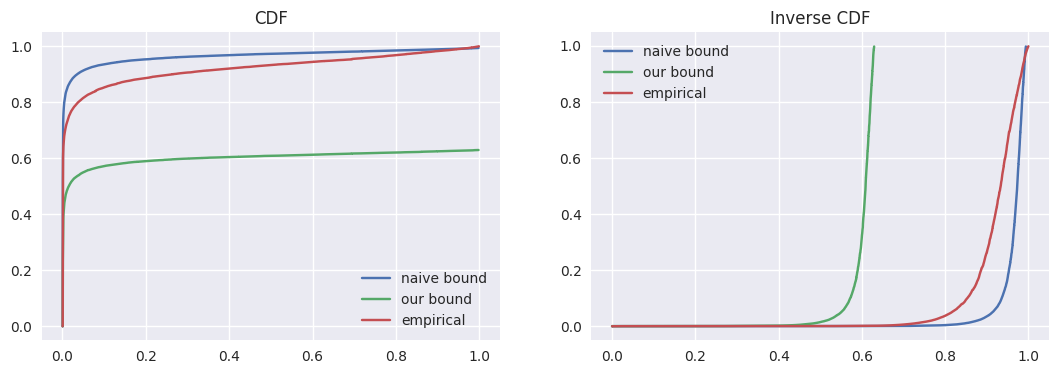

Median bounds
naive bound 0.000778715359047  | our bound 0.0150741003453731 | empirical 0.0008274248684756


In [459]:
plt.rcParams["figure.figsize"] = [13,4]
fig, axs = plt.subplots(1,2)

axs[0].plot(np.sort(z_source), b_source, label="naive bound")
axs[0].plot(np.sort(z_cal), b_inf, label="our bound")
# axs[0].plot(np.sort(z_target), b_target, label="target bound")
axs[0].plot(np.sort(z_tar), np.arange(z_tar.shape[0])/z_tar.shape[0], label="empirical")

axs[1].plot(b_source, np.sort(z_source), label="naive bound")
axs[1].plot(b_inf, np.sort(z_cal), label="our bound")
# axs[1].plot(b_target, np.sort(z_target), label="target bound")
axs[1].plot(np.arange(z_tar.shape[0])/z_tar.shape[0], np.sort(z_tar), label="empirical")

axs[0].set_title("CDF")
axs[1].set_title("Inverse CDF")

for ax in axs:
    ax.legend()

plt.show()

beta = 0.5

unshift_bound = np.sort(z_source)[(b_source < beta).sum()]
shift_bound = np.sort(z_cal)[(b_inf < beta).sum()]
target_bound = np.sort(z_target)[(b_target < beta).sum()]
emp_val = np.quantile(z_target, beta)

print("Median bounds")
print("naive bound", unshift_bound, " | our bound", shift_bound, "| empirical", emp_val)